In [1]:
import numpy as np
import seaborn as sns
import pandas as pd

import matplotlib.pyplot as plt

import keijzer_exogan as ke

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from glob import glob

from sklearn.metrics import r2_score
from scipy import stats

%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"} # Make sure the axis background of plots is white, this is usefull for the black theme in JupyterLab

# Initialize default seaborn layout
sns.set_palette(sns.hls_palette(8, l=.3, s=.8))
sns.set(style='ticks') 

# load inpainting data from the inpainting notebook(s)

In [4]:
# debug_0_5000_1_1e-1_c , Same inpainting settings as ExoGAN

general_name = 'debug_0_30000_1e-1_1_wgan_simple' # general filename, e.g. 'test' for test_reals.npy, test_inpainteds.npy... etc.

# get the file paths of the result files
reals = glob('gan_data//val_errors//'+general_name+'_reals.npy')
inpainteds = glob('gan_data//val_errors//'+general_name+'_inpainteds.npy')
n_iterations = glob('gan_data//val_errors//'+general_name+'_n_iterations.npy')


contextuals = glob('gan_data//val_errors//'+general_name+'_contextual_losses.npy')
perceptuals = glob('gan_data//val_errors//'+general_name+'_perceptual_losses.npy')

reals

['gan_data//val_errors//debug_0_30000_1e-1_1_wgan_simple_reals.npy']

In [5]:
# load arrays to list, convert list to ndarray with shape (aspa, n_inpaintings, height, width)
reals = np.concatenate([np.load(path) for path in reals], axis=0)
inpainteds = np.concatenate([np.load(path) for path in inpainteds], axis=0)

perceptuals = np.concatenate([np.load(path) for path in perceptuals], axis=0)
contextuals = np.concatenate([np.load(path) for path in contextuals], axis=0)

# take mean of the n_inpaintings per aspa
n_aspas = reals.shape[0]
reals = reals.mean(axis=1).reshape(n_aspas,1,32,32)
inpainteds = inpainteds.mean(axis=1).reshape(n_aspas,1,32,32)

In [6]:
reals.shape

(1191, 1, 32, 32)

In [7]:
reals.mean(1).shape

(1191, 32, 32)

# Error of ASPA $i$

In [8]:
"""
3739 is bad with errors: -20.025595	-59.902499	831.523538	-28.148670	22.250920	0.759872	-8.532101 (831% is CO)
4788 is good with errors: 4.121214	0.958426	0.045486	0.866588	-5.077431	-0.756804	2.978271
4998 is 'decent' with errors: 5.578141	7.753601	-6.975316	5.797133	39.391482	-1.526314	-41.867831
"""
i = 0 

decodeds =[ke.decode_params_from_aspa(inpainteds[i, j]) for j in range(reals.shape[1])]

df = pd.DataFrame.from_dict(decodeds)
df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

df.describe()

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
count,1.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000,1.000000
mean,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035
25%,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035
50%,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035
75%,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035
max,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035


In [9]:
df

,ch4_mixratio,co2_mixratio,co_mixratio,h2o_mixratio,planet_mass,planet_radius,temp_profile,perceptuals,contextuals
0,-4.278782,-7.843604,-3.182515,-7.725419,2.091618e+27,6.068287e+07,1637.432456,-0.048774,11.300035


In [10]:
if reals.shape[1] > 1 :
    params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

    fontsize = 16
    plt.figure(figsize=((25,10)))
    for i,param in enumerate(params):
        plt.subplot(3,3,i+1)
        plt.title(param, fontsize=fontsize)
        plt.hist(df[param], bins=25)

        # plot mean and median line
        mu = df[param].mean()
        plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
        plt.axvline(x=df[param].median(),  color='black', linestyle='-', alpha=1, label='median')

        # plot std lines
        plt.axvline(x=mu-df[param].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
        plt.axvline(x=mu+df[param].std(),  color='black', linestyle=':', alpha=1)

        plt.xticks(fontsize=fontsize)
        plt.yticks(fontsize=fontsize)

        plt.xlabel('Percentage error [%]', fontsize=fontsize)
        plt.ylabel('Counts [-]', fontsize=fontsize)

        plt.legend(fontsize=fontsize)
        plt.grid()
        plt.tight_layout()

In [11]:
reals.shape

(1191, 1, 32, 32)

In [12]:
#reals = reals.mean(axis=1) # take the mean of n_inpaintings per aspa, new shape is (aspa, height, width)
#inpainteds = inpainteds.mean(axis=1)

#reals = reals.reshape(reals.shape[0]*reals.shape[1], 32,32)
#inpainteds = inpainteds.reshape(inpainteds.shape[0]*inpainteds.shape[1], 32,32)

#from scipy import stats
#df = df[(np.abs(stats.zscore(df)) < 1).all(axis=1)]

reals.shape

(1191, 1, 32, 32)

In [13]:
reals.shape

(1191, 1, 32, 32)

## Spectrum plot

In [14]:
real = reals[i][0]
inpainted = inpainteds[i][0]

real.shape, inpainted.shape

((32, 32), (32, 32))

In [15]:
real_spec = real[:16, :25].flatten()
inpainted_spec = inpainted[:16, :25].flatten()

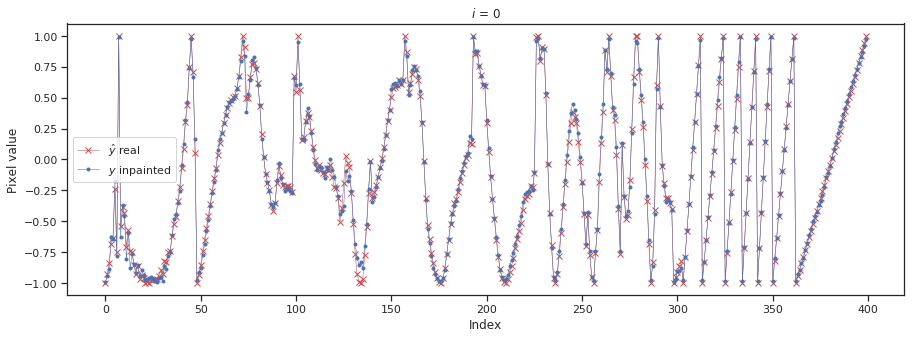

In [16]:
# :16, :25 is the spectrum location within the ASPA
plt.figure(figsize=(15,5))
plt.plot(real_spec, 'x-', c='r', linewidth=0.5, label=r'$\hat{y}$ real')
plt.plot(inpainted_spec, '.-', linewidth=0.5, label=r'$y$ inpainted')

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index')
plt.ylabel('Pixel value')
plt.legend()

# Pixel difference plot

Text(0, 0.5, '$y$-$\\hat{y}$')

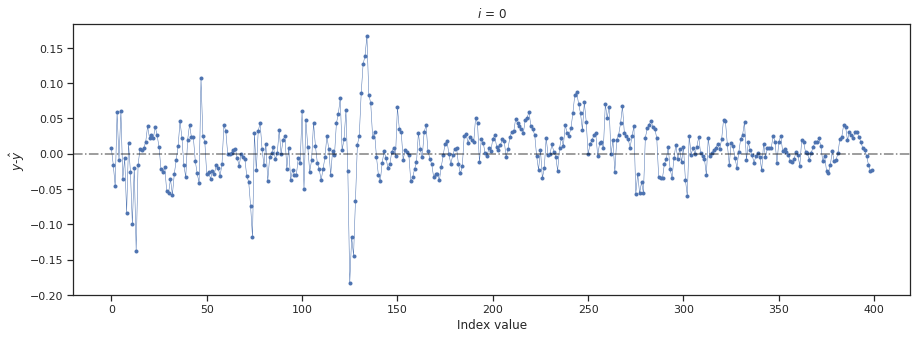

In [17]:
plt.figure(figsize=(15,5))

plt.plot(inpainted_spec - real_spec, '.-', linewidth=0.5)

plt.axhline(y=0,  color='black', linestyle='-.', alpha=0.5)

plt.title(r'$i$ = %s' % i)
plt.xlabel('Index value')
plt.ylabel(r'$y$-$\hat{y}$')

/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:376: RuntimeWarning: Mean of empty slice.
  mins_ = [aspa[16:17, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
/home/16011015/notebooks/SRON-DCGAN/notebooks/keijzer_exogan.py:377: RuntimeWarning: Mean of empty slice.
  maxs_ = [aspa[17:18, i*2:i*2+2].mean() for i in range(n_bins)]
/opt/jupyterhub/anaconda/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


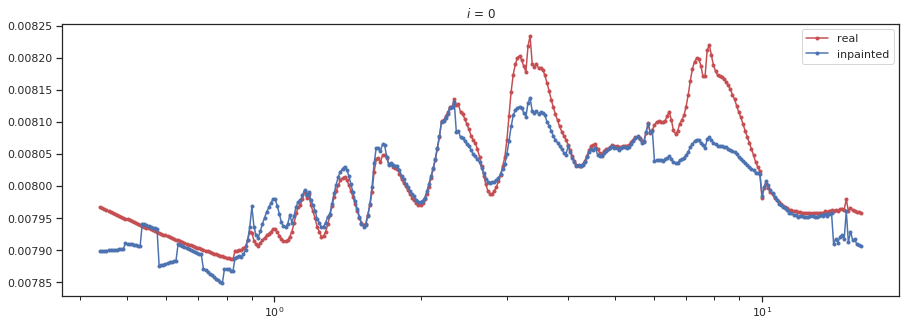

In [18]:
xhat,yhat = ke.decode_spectrum_from_aspa(real)
x,y  = ke.decode_spectrum_from_aspa(inpainted)

plt.figure(figsize=(15,5))
plt.plot(xhat, yhat, '.-', label='real', c='r')
plt.plot(x,y,'.-', label='inpainted')

plt.gca().set_xscale('log')

plt.title(r'$i$ = %s' % i)
plt.legend()

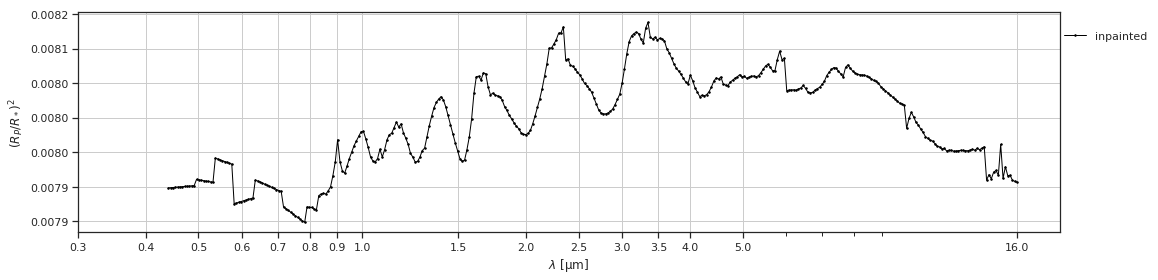

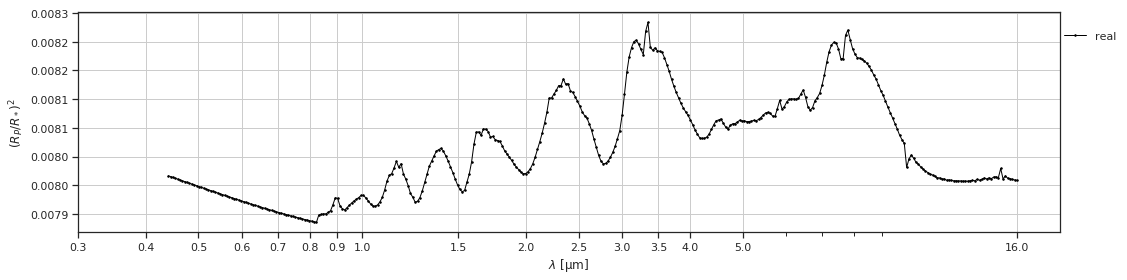

In [19]:
ke.plot_trans(x,y, label='inpainted')
ke.plot_trans(xhat,yhat, label='real')

# Error of all ASPAs

In [20]:
reals.shape

(1191, 1, 32, 32)

In [21]:
reals = [ke.decode_params_from_aspa(real[0]) for real in reals]
inpainteds = [ke.decode_params_from_aspa(inpainted[0]) for inpainted in inpainteds]

In [22]:
# create dfs for real, inpainted and their percentage errors

reals = pd.DataFrame.from_dict(reals)
inpainteds = pd.DataFrame.from_dict(inpainteds)
errors = (inpainteds - reals) / reals * 100

In [23]:
contextuals.shape

(1191,)

In [24]:
errors = errors.replace([np.inf, -np.inf], np.nan) # TODO: Fix the occurance of inf, this has to do with 0 Kelvin values

reals.columns = [column+'_real' for column in reals.columns]
inpainteds.columns = [column+'_inpainted' for column in inpainteds.columns]
errors.columns = [column+'_error' for column in errors.columns]

## Errors df

In [25]:
errors.describe()

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,13.447432,2.847815,12.040352,1.445556,8.486982,-0.369002,7.161407
std,53.929832,30.395392,73.145995,17.318269,42.128979,1.328085,32.945812
min,-68.517687,-65.786403,-87.033949,-78.117385,-59.883404,-6.162835,-49.948692
25%,-1.679725,-4.436363,-19.040090,-5.224076,-23.006160,-1.175557,-16.751277
50%,2.235468,-0.133030,0.254318,-1.207203,0.237644,-0.357972,3.233279
75%,10.331498,5.808999,17.972520,5.394238,30.514731,0.357439,26.933874
max,673.375392,684.040481,648.672870,208.328880,149.779952,4.373329,99.856740


In [26]:
errors[:10]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error
0,4.078482,-1.954961,-4.524545,-3.432267,37.751424,-1.113727,63.743246
1,18.490160,-4.116223,-12.822690,-9.749273,-33.092572,0.250825,25.667481
2,3.750136,1.791008,21.856058,1.778043,21.809848,0.644458,-5.847639
3,7.606054,4.357150,3.050742,-2.843808,6.454026,-0.430007,-22.012805
4,16.466278,-7.848651,5.906035,-0.800814,1.194495,-0.193322,-39.441064
5,4.763767,-1.967363,-63.501178,11.061209,-51.775369,-1.945427,81.756932
6,7.320341,-6.053412,14.830029,-3.352334,85.123636,-1.508599,22.582617
7,-4.310705,-4.863508,-36.972979,-3.071139,-29.428980,-0.686676,16.586710
8,1.983215,-10.440096,18.888241,-0.961655,-34.643525,-1.802933,52.419975
9,-0.299990,0.502660,1.494483,-0.648604,-5.423480,1.551211,-11.838721


In [27]:
errors[(errors.co_mixratio_error < 0.1) & (errors.co_mixratio_error > -0.1)]

,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error


In [28]:
### join the dfs together
df = reals.join(inpainteds, how='outer')
df = df.join(errors, how='outer')

df['perceptuals'] = pd.DataFrame(perceptuals)
df['contextuals'] = pd.DataFrame(contextuals)

In [29]:
df.describe()

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
count,1191.000000,1191.000000,1191.000000,1191.000000,1.191000e+03,1.191000e+03,1191.000000,1191.000000,1191.000000,1191.000000,...,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,-4.457879,-4.517306,-4.557795,-4.644650,2.677067e+27,8.056886e+07,1499.020431,-4.690656,-4.525581,-4.563376,...,1531.653032,13.447432,2.847815,12.040352,1.445556,8.486982,-0.369002,7.161407,-0.087626,17.037663
std,2.227931,2.216826,2.290808,2.221567,7.383716e+26,1.583852e+07,322.540133,2.194776,2.225527,2.364743,...,325.640373,53.929832,30.395392,73.145995,17.318269,42.128979,1.328085,32.945812,0.022684,23.186369
min,-8.000000,-8.000000,-8.000000,-8.000000,1.518400e+27,5.592880e+07,1000.000000,-7.998367,-7.990292,-7.973987,...,1000.016481,-68.517687,-65.786403,-87.033949,-78.117385,-59.883404,-6.162835,-49.948692,-0.156903,6.218528
25%,-6.444445,-6.444445,-6.444445,-6.444445,2.024533e+27,6.680384e+07,1222.222209,-6.553861,-6.550554,-6.911814,...,1235.295147,-1.679725,-4.436363,-19.040090,-5.224076,-23.006160,-1.175557,-16.751277,-0.101728,9.945521
50%,-4.111111,-4.888889,-4.888889,-4.888889,2.783733e+27,8.311641e+07,1555.555556,-4.862647,-4.640804,-4.579025,...,1556.350496,2.235468,-0.133030,0.254318,-1.207203,0.237644,-0.357972,3.233279,-0.085160,11.752304
75%,-2.555556,-2.555556,-2.555556,-2.555556,3.289867e+27,9.399146e+07,1777.777791,-2.704376,-2.453050,-2.257154,...,1826.939374,10.331498,5.808999,17.972520,5.394238,30.514731,0.357439,26.933874,-0.071713,14.394567
max,-1.000000,-1.000000,-1.000000,-1.000000,3.796000e+27,1.048665e+08,2000.000000,-1.104566,-1.010013,-1.009057,...,1999.239922,673.375392,684.040481,648.672870,208.328880,149.779952,4.373329,99.856740,-0.021149,187.177704


In [30]:
df[:10]

,ch4_mixratio_real,co2_mixratio_real,co_mixratio_real,h2o_mixratio_real,planet_mass_real,planet_radius_real,temp_profile_real,ch4_mixratio_inpainted,co2_mixratio_inpainted,co_mixratio_inpainted,...,temp_profile_inpainted,ch4_mixratio_error,co2_mixratio_error,co_mixratio_error,h2o_mixratio_error,planet_mass_error,planet_radius_error,temp_profile_error,perceptuals,contextuals
0,-4.111111,-8.000000,-3.333334,-8.000000,1.518400e+27,6.136632e+07,1000.000000,-4.278782,-7.843604,-3.182515,...,1637.432456,4.078482,-1.954961,-4.524545,-3.432267,37.751424,-1.113727,63.743246,-0.048774,11.300035
1,-1.000000,-4.111111,-4.111111,-8.000000,3.542933e+27,5.592880e+07,1555.555556,-1.184902,-3.941889,-3.583956,...,1954.827487,18.490160,-4.116223,-12.822690,-9.749273,-33.092572,0.250825,25.667481,-0.118635,6.511411
2,-6.444445,-6.444445,-1.000000,-3.333334,2.783733e+27,7.224137e+07,2000.000000,-6.686120,-6.559865,-1.218561,...,1883.047223,3.750136,1.791008,21.856058,1.778043,21.809848,0.644458,-5.847639,-0.068524,13.180271
3,-2.555556,-3.333334,-1.000000,-4.111111,2.277600e+27,7.767889e+07,1666.666672,-2.749933,-3.478572,-1.030507,...,1299.786583,7.606054,4.357150,3.050742,-2.843808,6.454026,-0.430007,-22.012805,-0.079286,9.713638
4,-6.444445,-4.111111,-7.222222,-3.333334,1.771467e+27,6.680384e+07,2000.000000,-7.505605,-3.788444,-7.648769,...,1211.178720,16.466278,-7.848651,5.906035,-0.800814,1.194495,-0.193322,-39.441064,-0.090605,10.467453
5,-2.555556,-4.111111,-5.666667,-1.000000,3.289867e+27,1.048665e+08,1000.000000,-2.677296,-4.030231,-2.068267,...,1817.569315,4.763767,-1.967363,-63.501178,11.061209,-51.775369,-1.945427,81.756932,-0.061105,12.187748
6,-1.777778,-8.000000,-1.000000,-2.555556,2.024533e+27,1.048665e+08,1333.333328,-1.907917,-7.515727,-1.148300,...,1634.434894,7.320341,-6.053412,14.830029,-3.352334,85.123636,-1.508599,22.582617,-0.051356,11.316118
7,-3.333334,-4.888889,-1.777778,-4.888889,3.796000e+27,6.136632e+07,1444.444444,-3.189643,-4.651118,-1.120480,...,1684.030250,-4.310705,-4.863508,-36.972979,-3.071139,-29.428980,-0.686676,16.586710,-0.101490,8.942486
8,-5.666667,-2.555556,-6.444445,-2.555556,3.796000e+27,8.855393e+07,1111.111104,-5.779049,-2.288753,-7.661687,...,1693.555266,1.983215,-10.440096,18.888241,-0.961655,-34.643525,-1.802933,52.419975,-0.071460,10.831016
9,-8.000000,-3.333334,-4.888889,-5.666667,3.542933e+27,6.680384e+07,1777.777791,-7.976001,-3.350089,-4.961953,...,1567.311645,-0.299990,0.502660,1.494483,-0.648604,-5.423480,1.551211,-11.838721,-0.104561,10.357798


In [31]:
#df = df.drop(['temp_profile_error','temp_profile_real','temp_profile_inpainted'], axis=1)

# Percentage error histograms per retrieved parameter

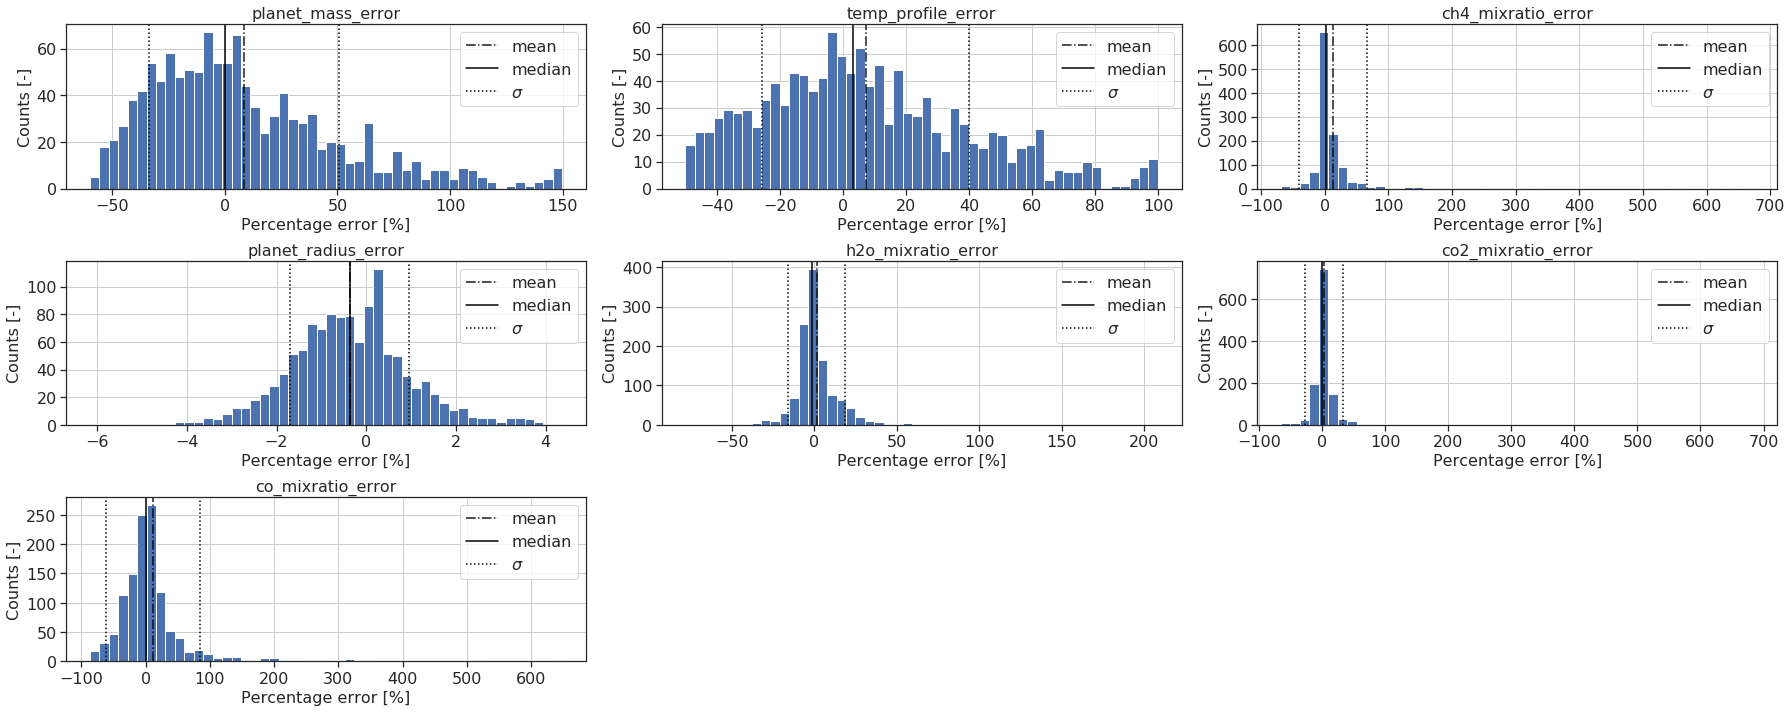

In [32]:
params = ['planet_mass','temp_profile','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']
#params = ['planet_mass','ch4_mixratio','planet_radius','h2o_mixratio','co2_mixratio','co_mixratio']

fontsize = 16
plt.figure(figsize=((25,10)))
for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.title(param+'_error', fontsize=fontsize)
    plt.hist(df[param+'_error'], bins=50)
    
    # plot mean and median line
    mu = df[param+'_error'].mean()
    plt.axvline(x=mu,  color='black', linestyle='-.', alpha=0.9, label='mean')
    plt.axvline(x=df[param+'_error'].median(),  color='black', linestyle='-', alpha=1, label='median')

    # plot std lines
    plt.axvline(x=mu-df[param+'_error'].std(),  color='black', linestyle=':', alpha=1, label=r'$\sigma$')
    plt.axvline(x=mu+df[param+'_error'].std(),  color='black', linestyle=':', alpha=1)
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel('Percentage error [%]', fontsize=fontsize)
    plt.ylabel('Counts [-]', fontsize=fontsize)
    
    plt.legend(fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# Grab the $n$ sigma errors

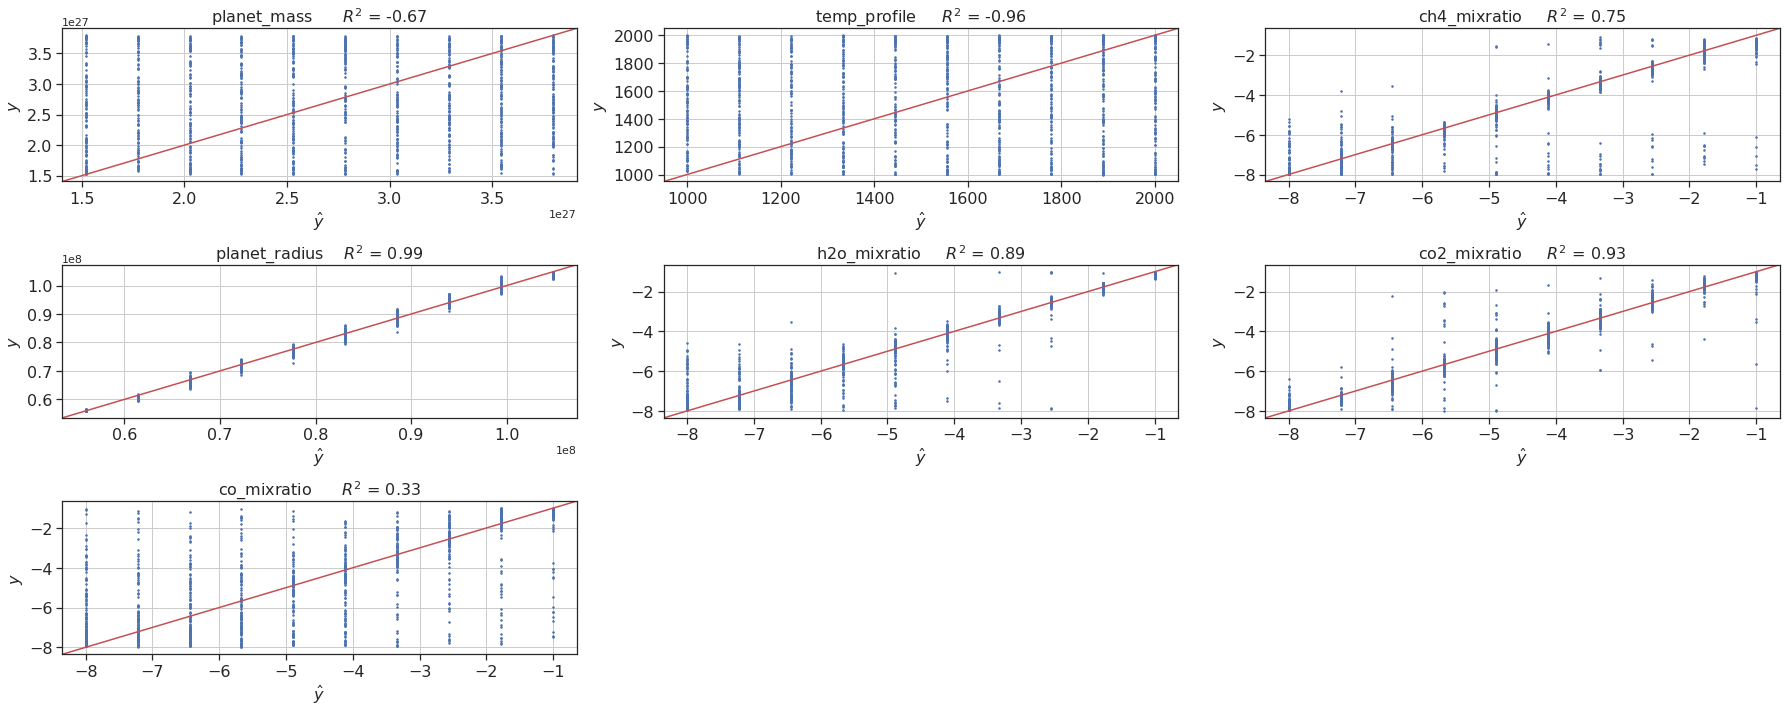

In [33]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    y_hat = df[param+'_real']
    y = df[param+'_inpainted']
    
    r2 = r2_score(y_hat, y)
    
    plt.subplot(3,3,i+1)

    plt.title(param +' \t $R^2$ = %.2f' % r2, fontsize=fontsize)
    plt.plot(y_hat, y, '.', ms=3)
    
    """Force x,y range on the same scale outliers outside of range wont be plotted!"""
    x_min, x_max = plt.xlim()
    x_min = x_min*1
    x_max = x_max*1
    
    plt.ylim((x_min, x_max)) # set y axis range the same as x axis range
    plt.xlim((x_min, x_max))
    
    # Plot the red 'perfect' prediction line
    plt.plot(plt.xlim(), plt.ylim(), ls="-", c='r')
    
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.xlabel(r"$\hat{y}$", fontsize=fontsize)
    plt.ylabel(r"$y$", fontsize=fontsize)
    plt.grid()
    plt.tight_layout()

# 1$\sigma$ percentage error per parameter

### Unique values STD plot
y axis, STD  
X axis, unique values  

This plot shows the STD per parameter value (10 values for ExoGAN data)

Horizontal -. line is the 10% line

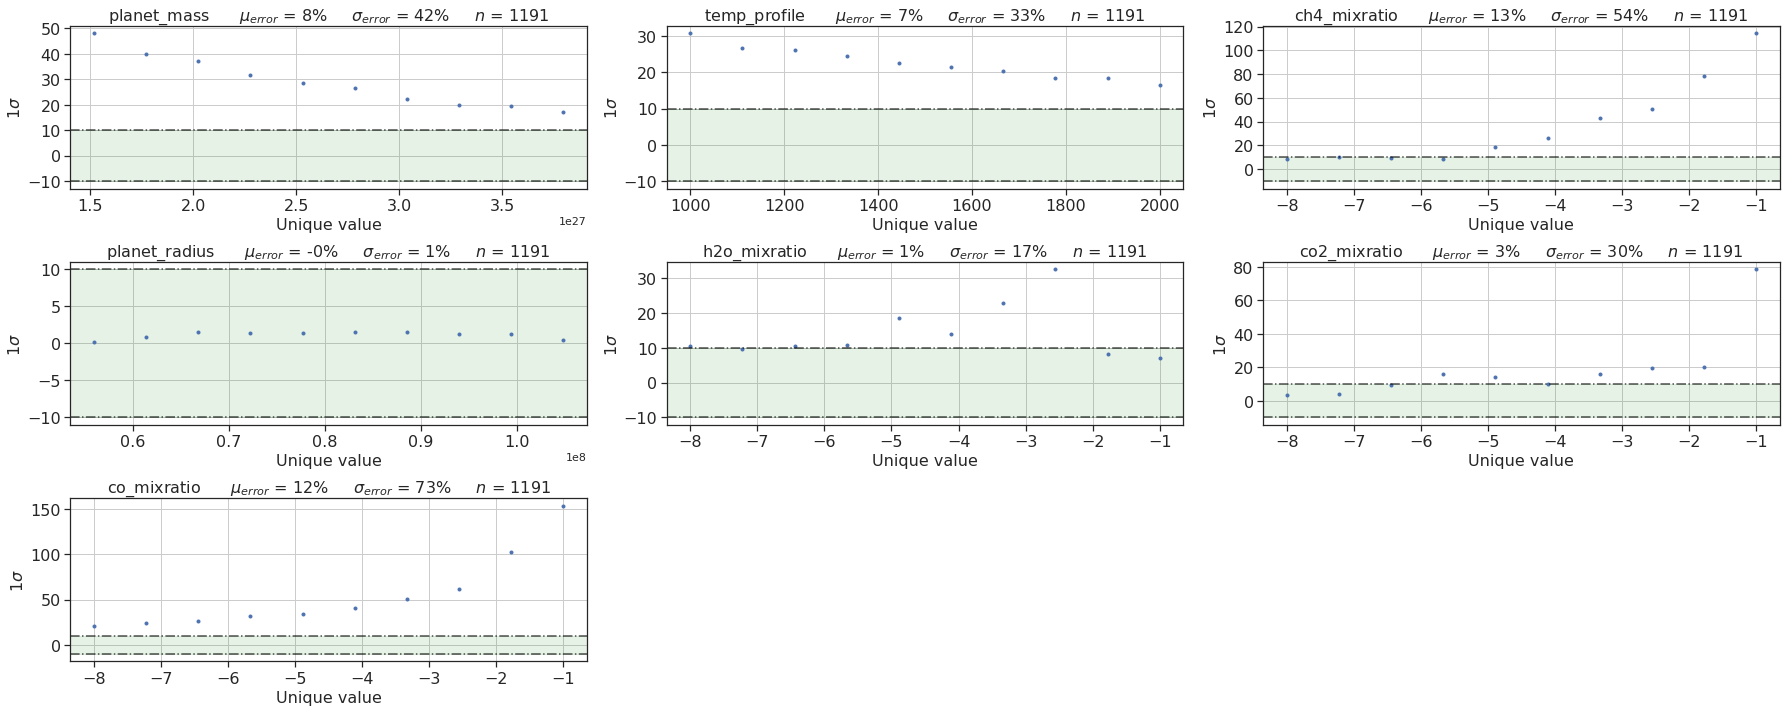

In [34]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    uniques = df[param+'_real'].unique()
    
    counts = []
    stds = []
    for unique in uniques:
        t = df[param+'_error'][(df[param+'_real'] == unique)]
        std = t.std()
        count = t.count()
        #print(count, std)

        counts.append(count)
        stds.append(std)

    plt.subplot(3,3,i+1)
    plt.plot(uniques, stds, '.')
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Unique value', fontsize=fontsize)
    plt.ylabel(r'1$\sigma$', fontsize=fontsize)
    plt.tight_layout()
    

In [35]:
iters = [np.load(iters) for iters in n_iterations]
iters

[array([], dtype=float64)]

In [36]:
uniques

array([-3.33333351, -4.11111126, -1.        , -7.22222248, -5.66666691,
       -1.77777794, -6.44444475, -4.88888907, -8.00000042, -2.55555567])

# Losses

In [37]:
df[['perceptuals', 'contextuals']].describe()

,perceptuals,contextuals
count,1191.000000,1191.000000
mean,-0.087626,17.037663
std,0.022684,23.186369
min,-0.156903,6.218528
25%,-0.101728,9.945521
50%,-0.085160,11.752304
75%,-0.071713,14.394567
max,-0.021149,187.177704


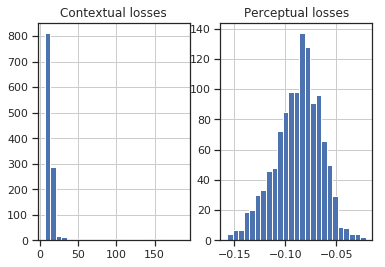

In [38]:
plt.subplot(1,2,1)
plt.hist(df.contextuals, bins=25)
plt.title('Contextual losses')
plt.grid()

plt.subplot(1,2,2)
plt.hist(df.perceptuals, bins=25)
plt.title('Perceptual losses')
plt.grid()

# Param percentage errors vs contextual loss
For contextual loss, lower is better.

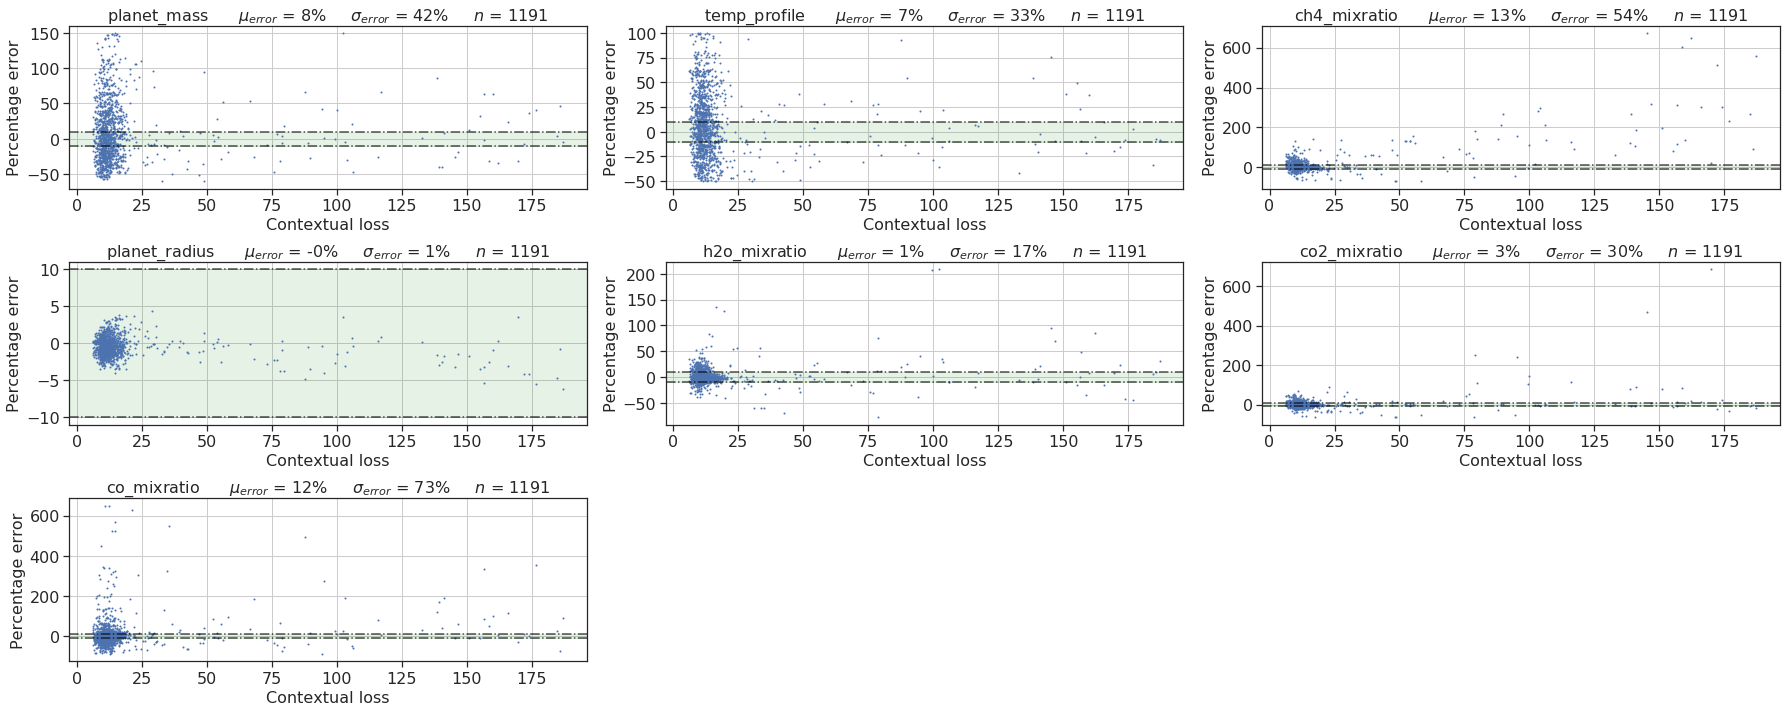

In [39]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.contextuals, df[param+'_error'], '.', ms=2)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    #plt.ylim((-100,100))
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Contextual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    #plt.legend()
    plt.tight_layout()
    

# Param percentage errors vs perceptual loss
For perceptual loss, lower is better.

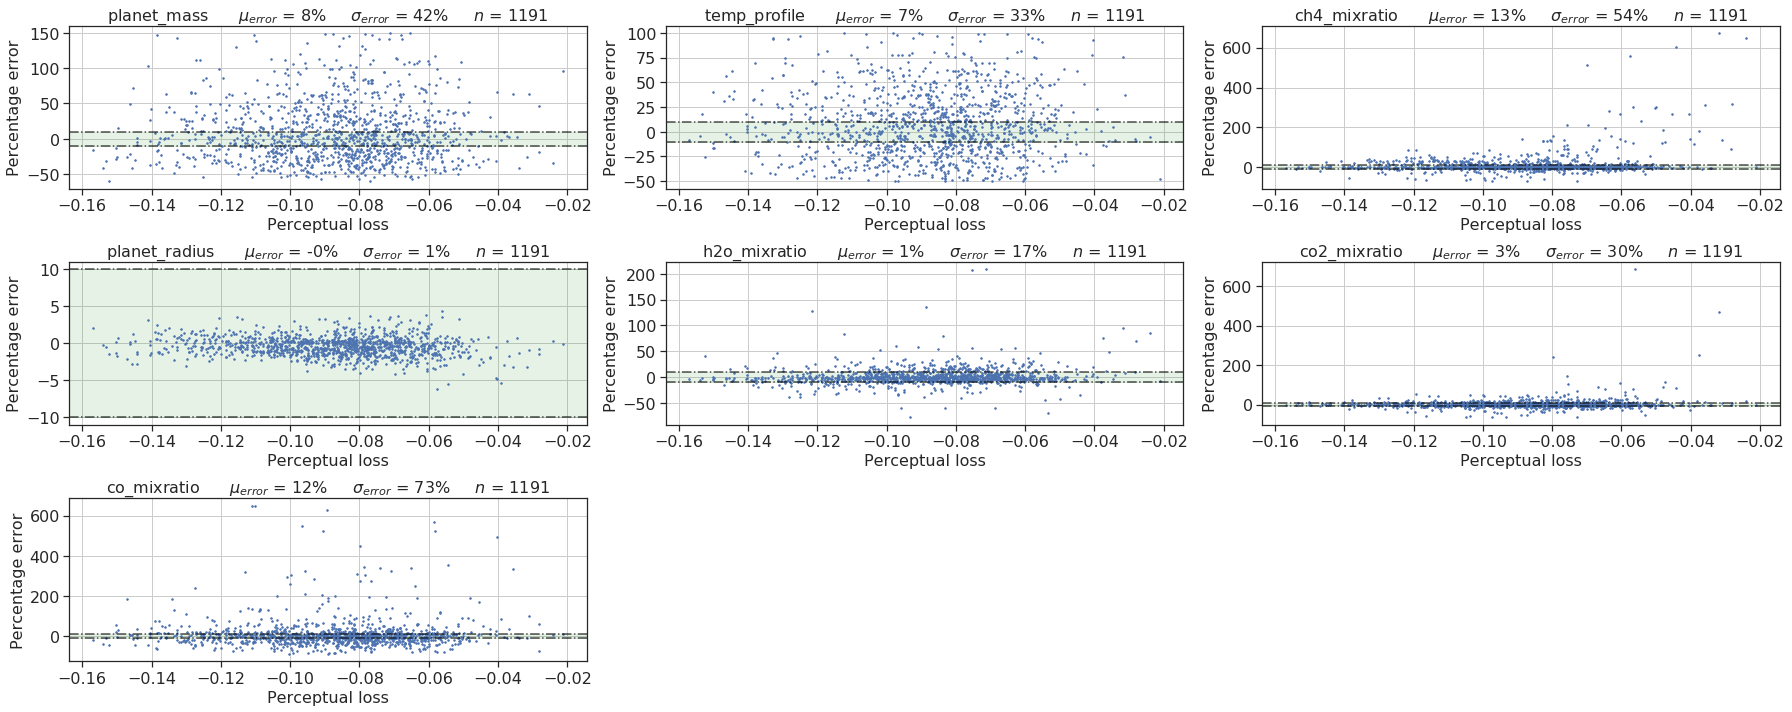

In [40]:
plt.figure(figsize=((25,10)))

for i,param in enumerate(params):
    plt.subplot(3,3,i+1)
    plt.plot(df.perceptuals, df[param+'_error'], '.', ms=3)
    
    plt.axhline(y=10,  color='black', linestyle='-.', alpha=0.7, label='10%')
    plt.axhline(y=-10,  color='black', linestyle='-.', alpha=0.7)
    plt.axhspan(10, -10, alpha=0.1, color='green')
    
    """layout"""""
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    
    plt.grid()
    title_text = r'%s      $\mu_{error}$ = %.0f%%     $\sigma_{error}$ = %.0f%%     $n$ = %s' % (param, df[param+'_error'].mean(), df[param+'_error'].std(), len(df))
    plt.title(title_text, fontsize=fontsize)
    plt.xlabel('Perceptual loss', fontsize=fontsize)
    plt.ylabel(r'Percentage error', fontsize=fontsize)
    plt.tight_layout()